In [959]:
#This script performs several setps of time series analyis
# First section: Order selection for ARIMAX model based on lowest AIC and BIC
# Second section: Testing for model performance improvement

# The aim of our research is not to identify multicollinearity, endogeneity, the only purpose is to test in all the following scripts whether the predictive power of two different models can be improved.

import pandas as pd
import numpy as np
import pickle
import random
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import probplot
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


import warnings
warnings.filterwarnings('ignore')
random.seed(42)

df = pd.read_csv("./tsdata/modeldata.csv", index_col='Date', parse_dates=True)
df.index.freq = "MS"


train = df[:'2020-01-01']
test = df['2020-01-02':]

In [960]:
#Model fitting
y = train['returns']
X_msci = train[["msci"]]
X_sent = train[["sentiment"]] #"sentiment" is our own sentiment score derived fromt the sentiment LDA
X_both = train[["msci","sentiment"]]#Both the MSCI and the sentiment score are included


ytest = test["returns"]

Xmsci_test = test[["msci"]]
Xsent_test = test[["sentiment"]]
Xboth_test = test[["msci", "sentiment"]]


def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

def rmse(actual, pred):
    return np.sqrt(mean_squared_error(actual, pred))


def evaluateModel(data, exog, order, actual, exogtest):
    model = SARIMAX(data, exog=exog, order=(order[0], 0, order[1]), enforce_stationarity=True, enforce_invertibility=True)
    model_fit = model.fit(disp=False, maxiter = 300)
    prediction = model_fit.get_forecast(steps=len(ytest), exog=exogtest).predicted_mean
    MAPE_f = mape(actual, prediction)
    RMSE_f = rmse(actual, prediction)
    return order, model_fit.aic, model_fit.bic, MAPE_f, RMSE_f

orders = [(p, q) for p in range(5) for q in range(5) if (p, q) != (0, 0)]

results_base = []
results_msci = []
results_sent = []
results_both = []

#Base model
for order in orders:
    try:
        order, aic, bic, MAPE_base, RMSE_base = evaluateModel(y, None, order, ytest, None)
        results_base.append([order, aic, bic, MAPE_base, RMSE_base])
    except Exception as e:
        print(f"Order {order} for base model failed: {e}")


#Including MSCI
for order in orders:
    try:
        order, aic_msci, bic_msci, MAPE_msci, RMSE_msci = evaluateModel(y, X_msci, order, ytest, Xmsci_test)
        results_msci.append([order, aic_msci, bic_msci, MAPE_msci, RMSE_msci])
    except Exception as e:
        print(f"Order {order} with msci failed: {e}")

#Including own sentiment score
for order in orders:
    try:
        order, aic_sent, bic_sent, MAPE_sent, RMSE_sent = evaluateModel(y, X_sent, order, ytest, Xsent_test)
        results_sent.append([order, aic_sent, bic_sent, MAPE_sent, RMSE_sent])
    except Exception as e:
        print(f"Order {order} with sentiment failed: {e}")


#Including both scores
for order in orders:
    try:
        order, aic_both, bic_both, MAPE_both, RMSE_both = evaluateModel(y, X_both, order, ytest, Xboth_test)
        results_both.append([order, aic_both, bic_both, MAPE_both, RMSE_both])
    except Exception as e:
        print(f"Order {order} with both variables failed: {e}")


df_base = pd.DataFrame(results_base, columns=['Order', 'AIC', 'BIC', "MAPE", "RMSE"])
df_msci = pd.DataFrame(results_msci, columns=['Order', 'AIC', 'BIC', "MAPE", "RMSE"])
df_sent = pd.DataFrame(results_sent, columns=['Order', 'AIC', 'BIC', "MAPE", "RMSE"])
df_both = pd.DataFrame(results_both, columns=['Order', 'AIC', 'BIC', "MAPE", "RMSE"])

In [961]:
basemodel = SARIMAX(y, None, order=(1, 0, 1), enforce_stationarity=True, enforce_invertibility=True)
basefit = basemodel.fit(disp=False, maxiter = 300)
basefit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                   97
Model:               SARIMAX(1, 0, 1)   Log Likelihood                  34.329
Date:                Sat, 20 Apr 2024   AIC                            -62.658
Time:                        17:39:38   BIC                            -54.934
Sample:                    01-01-2012   HQIC                           -59.535
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   1.21e-05   8.24e+04      0.000       1.000       1.000
ma.L1         -0.9990      0.089    -11.209      0.000      -1.174      -0.824
sigma2         0.0270      0.005      5.370      0.000       0.017       0.037
===================================================================================
Ljung-Box (L1) (Q):                   1.56   Jarque-Bera (JB):                 3.79
Prob(Q):                              0.21   Prob(JB):                         0.15
Heteroskedasticity (H):               1.12   Skew:                            -0.47
Prob(H) (two-sided):                  0.76   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [962]:
acorr_ljungbox(basefit.resid, lags=[10], return_df=False)

,lb_stat,lb_pvalue
10,10.283894,0.415949


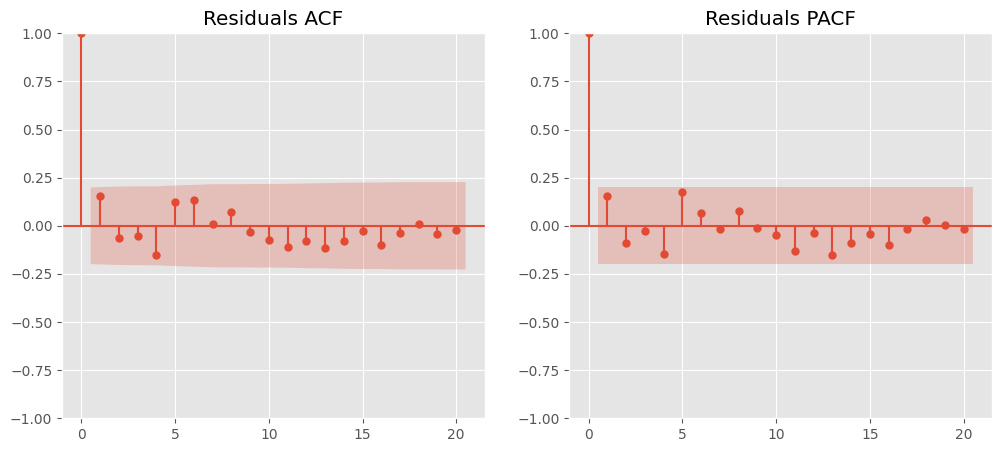

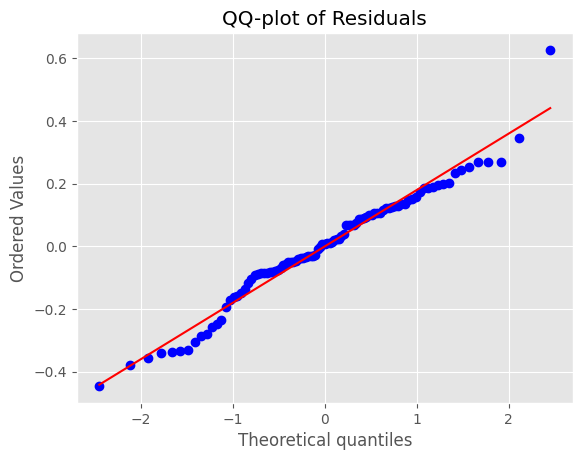

In [963]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(basefit.resid, ax=plt.gca(), title='Residuals ACF')
plt.subplot(122)
plot_pacf(basefit.resid, ax=plt.gca(), title='Residuals PACF')
plt.show()

# QQ-plot to check for normality
plt.figure()
probplot(basefit.resid, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')
plt.show()

In [964]:
mscimodel = SARIMAX(y, X_msci, order=(1, 0, 1), enforce_stationarity=True, enforce_invertibility=True)
mscifit = mscimodel.fit(disp=False, maxiter = 300)
mscifit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                   97
Model:               SARIMAX(1, 0, 1)   Log Likelihood                  34.373
Date:                Sat, 20 Apr 2024   AIC                            -60.746
Time:                        17:39:39   BIC                            -50.447
Sample:                    01-01-2012   HQIC                           -56.582
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
msci           0.0772      0.318      0.243      0.808      -0.546       0.701
ar.L1          1.0000   3.18e-05   3.15e+04      0.000       1.000       1.000
ma.L1         -0.9988      0.197     -5.060      0.000      -1.386      -0.612
sigma2         0.0270      0.007      3.803      0.000       0.013       0.041
===================================================================================
Ljung-Box (L1) (Q):                   1.56   Jarque-Bera (JB):                 3.69
Prob(Q):                              0.21   Prob(JB):                         0.16
Heteroskedasticity (H):               1.11   Skew:                            -0.47
Prob(H) (two-sided):                  0.76   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [965]:
acorr_ljungbox(mscifit.resid, lags=[10], return_df=False)

,lb_stat,lb_pvalue
10,10.520631,0.396062


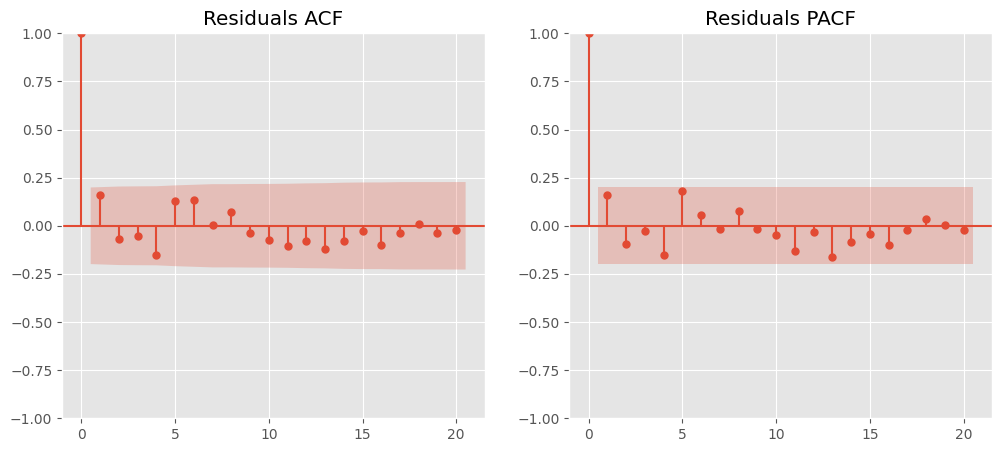

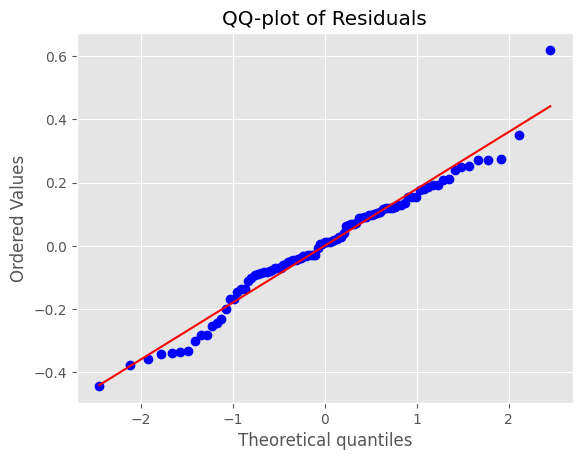

In [966]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(mscifit.resid, ax=plt.gca(), title='Residuals ACF')
plt.subplot(122)
plot_pacf(mscifit.resid, ax=plt.gca(), title='Residuals PACF')
plt.show()

# QQ-plot to check for normality
plt.figure()
probplot(mscifit.resid, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')
plt.show()

In [967]:
sentmodel = SARIMAX(y, X_sent, order=(1, 0, 1), enforce_stationarity=True, enforce_invertibility=True)
sentfit = sentmodel.fit(disp=False, maxiter = 300)
sentfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                   97
Model:               SARIMAX(1, 0, 1)   Log Likelihood                  34.433
Date:                Sat, 20 Apr 2024   AIC                            -60.867
Time:                        17:39:39   BIC                            -50.568
Sample:                    01-01-2012   HQIC                           -56.703
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sentiment      0.0312      0.063      0.495      0.621      -0.092       0.155
ar.L1          1.0000   6.75e-06   1.48e+05      0.000       1.000       1.000
ma.L1         -0.9991      0.054    -18.639      0.000      -1.104      -0.894
sigma2         0.0269      0.005      5.921      0.000       0.018       0.036
===================================================================================
Ljung-Box (L1) (Q):                   1.28   Jarque-Bera (JB):                 3.85
Prob(Q):                              0.26   Prob(JB):                         0.15
Heteroskedasticity (H):               1.09   Skew:                            -0.48
Prob(H) (two-sided):                  0.80   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [968]:
acorr_ljungbox(sentfit.resid, lags=[10], return_df=False)

,lb_stat,lb_pvalue
10,9.981011,0.442161


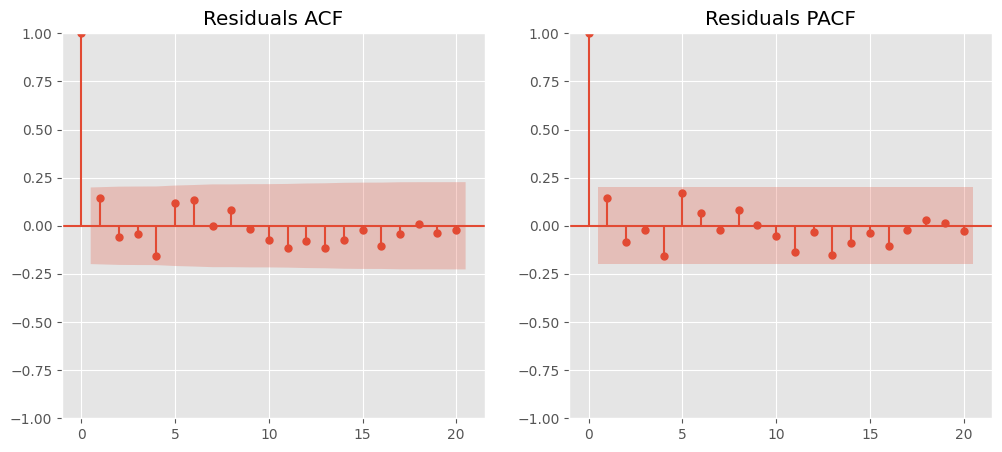

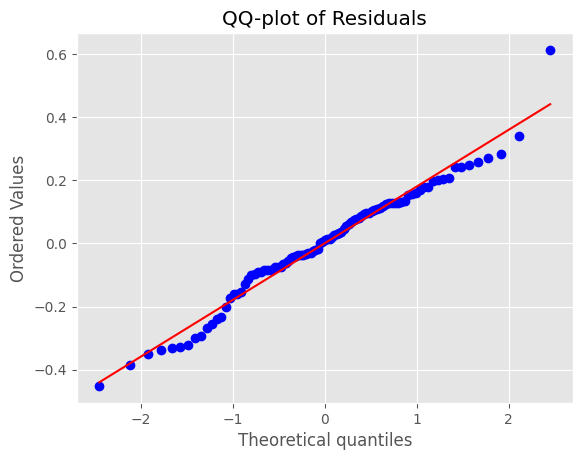

In [969]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(sentfit.resid, ax=plt.gca(), title='Residuals ACF')
plt.subplot(122)
plot_pacf(sentfit.resid, ax=plt.gca(), title='Residuals PACF')
plt.show()

# QQ-plot to check for normality
plt.figure()
probplot(sentfit.resid, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')
plt.show()

In [970]:
bothmodel = SARIMAX(y, X_both, order=(1, 0, 1), enforce_stationarity=True, enforce_invertibility=True)
bothfit = bothmodel.fit(disp=False, maxiter = 300)
bothfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                   97
Model:               SARIMAX(1, 0, 1)   Log Likelihood                  34.468
Date:                Sat, 20 Apr 2024   AIC                            -58.936
Time:                        17:39:40   BIC                            -46.062
Sample:                    01-01-2012   HQIC                           -53.730
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
msci           0.0699      0.313      0.223      0.823      -0.544       0.684
sentiment      0.0302      0.063      0.481      0.631      -0.093       0.154
ar.L1          1.0000   3.55e-05   2.81e+04      0.000       1.000       1.000
ma.L1         -0.9988      0.210     -4.750      0.000      -1.411      -0.587
sigma2         0.0269      0.007      3.643      0.000       0.012       0.041
===================================================================================
Ljung-Box (L1) (Q):                   1.29   Jarque-Bera (JB):                 3.73
Prob(Q):                              0.26   Prob(JB):                         0.15
Heteroskedasticity (H):               1.09   Skew:                            -0.47
Prob(H) (two-sided):                  0.81   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [971]:
acorr_ljungbox(bothfit.resid, lags=[10], return_df=False)

,lb_stat,lb_pvalue
10,10.169767,0.425727


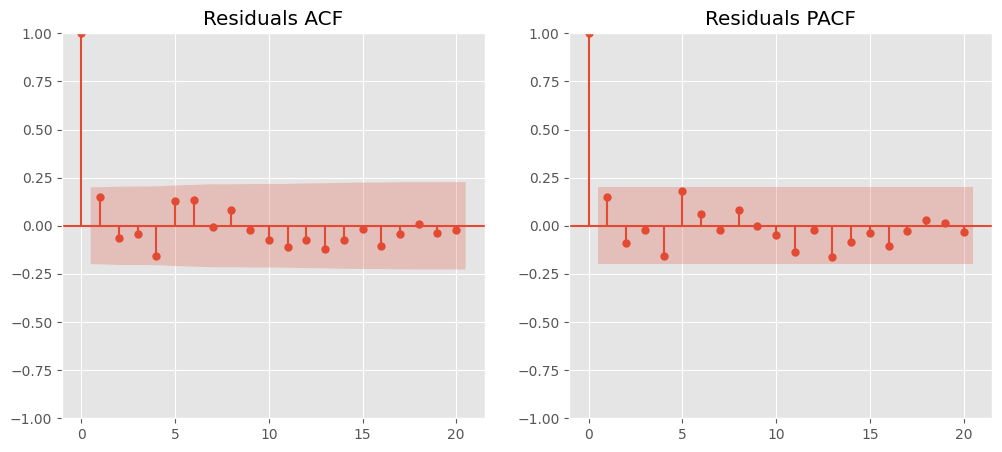

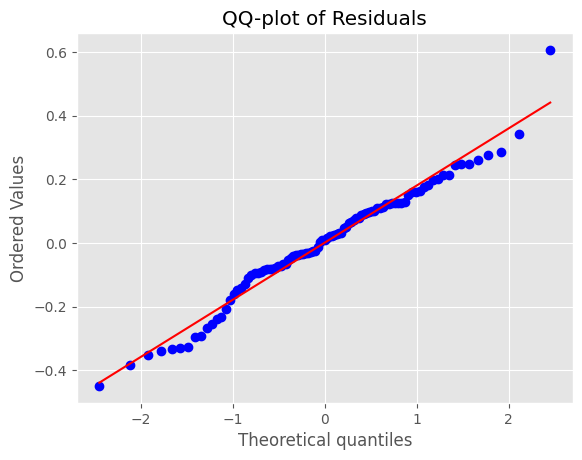

In [972]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(bothfit.resid, ax=plt.gca(), title='Residuals ACF')
plt.subplot(122)
plot_pacf(bothfit.resid, ax=plt.gca(), title='Residuals PACF')
plt.show()

# QQ-plot to check for normality
plt.figure()
probplot(bothfit.resid, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')
plt.show()

In [973]:
pbase = basefit.get_forecast(steps=len(ytest), exog=None).predicted_mean
pmsci = mscifit.get_forecast(steps=len(ytest), exog=Xmsci_test).predicted_mean
psent = sentfit.get_forecast(steps=len(ytest), exog=Xsent_test).predicted_mean
pboth = bothfit.get_forecast(steps=len(ytest), exog=Xboth_test).predicted_mean

errors = {
    'Model': ['Base', 'MSCI', 'Sentiment', 'Both'],
    'MAPE': [mape(ytest, pbase), mape(ytest, pmsci), mape(ytest, psent), mape(ytest, pboth)],
    'RMSE': [rmse(ytest, pbase), rmse(ytest, pmsci), rmse(ytest, psent), rmse(ytest, pboth)]
}

results_df = pd.DataFrame(errors)
print(results_df)

       Model        MAPE      RMSE
0       Base  511.557500  0.268669
1       MSCI  506.721687  0.269651
2  Sentiment  500.275881  0.269045
3       Both  496.235794  0.269917


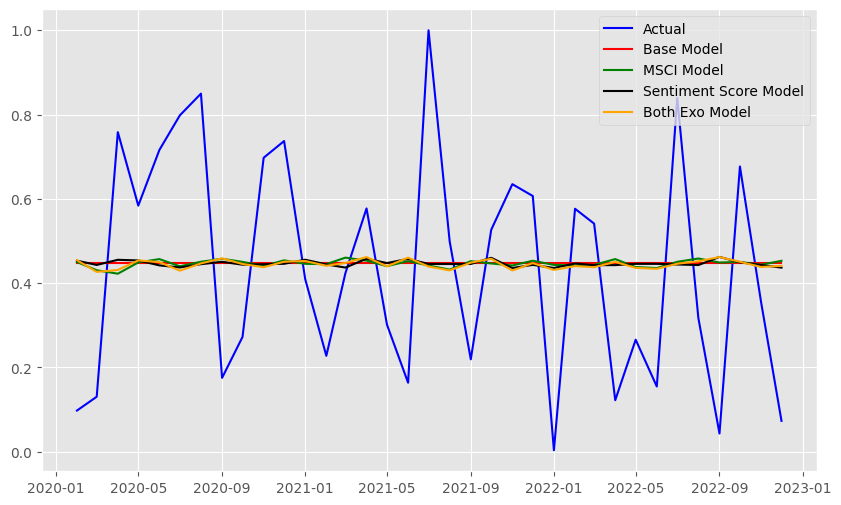

In [974]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, ytest, label='Actual', color='blue')
plt.plot(test.index, pbase, label='Base Model', color='red')
plt.plot(test.index, pmsci, label='MSCI Model', color='green')
plt.plot(test.index, psent, label='Sentiment Score Model', color='black')
plt.plot(test.index, pboth, label='Both Exo Model', color='orange')
plt.legend()

In [975]:
portfolio = pd.read_csv("./tsdata/portfolio.csv", index_col='Date', parse_dates=True)
df.index.freq = "MS"
log_returns = np.log(portfolio["0"] / portfolio["0"].shift(1)).dropna()

p_train = portfolio[:'2020-01-01']
p_test = portfolio['2020-01-02':]

with open("scaler_returns.pkl", 'rb') as file:
    scaler = pickle.load(file)

predictions = pd.DataFrame()
predictions["Base"]= pbase.values
predictions["Msci"]= pmsci.values
predictions["Sent"]= psent.values
predictions["Both"]= pboth.values

logret_pred = pd.DataFrame()
logret_pred["Base"] = np.exp(scaler.inverse_transform(predictions["Base"].values.reshape(-1, 1)).flatten())
logret_pred["Msci"] = np.exp(scaler.inverse_transform(predictions["Msci"].values.reshape(-1, 1)).flatten())
logret_pred["Sent"] = np.exp(scaler.inverse_transform(predictions["Sent"].values.reshape(-1, 1)).flatten())
logret_pred["Both"] = np.exp(scaler.inverse_transform(predictions["Both"].values.reshape(-1, 1)).flatten())


def generate_portfolio_series(base_price, returns):
    series = [base_price]
    for r in returns:
        series.append(series[-1] * r)
    return series

portfolio_series_df = pd.DataFrame()
portfolio_series_df['Base'] = generate_portfolio_series(p_test.iloc[0], logret_pred["Base"].values)
portfolio_series_df['Msci'] = generate_portfolio_series(p_test.iloc[0], logret_pred["Msci"].values)
portfolio_series_df['Sent'] = generate_portfolio_series(p_test.iloc[0], logret_pred["Sent"].values)
#portfolio_series_df['Both'] = generate_portfolio_series(p_test.iloc[0], logret_pred["Both"].values)
portfolio_series_df.drop(portfolio_series_df.tail(1).index,inplace=True)
portfolio_series_df.index = test.index
portfolio_series_df["Actual"] = p_test

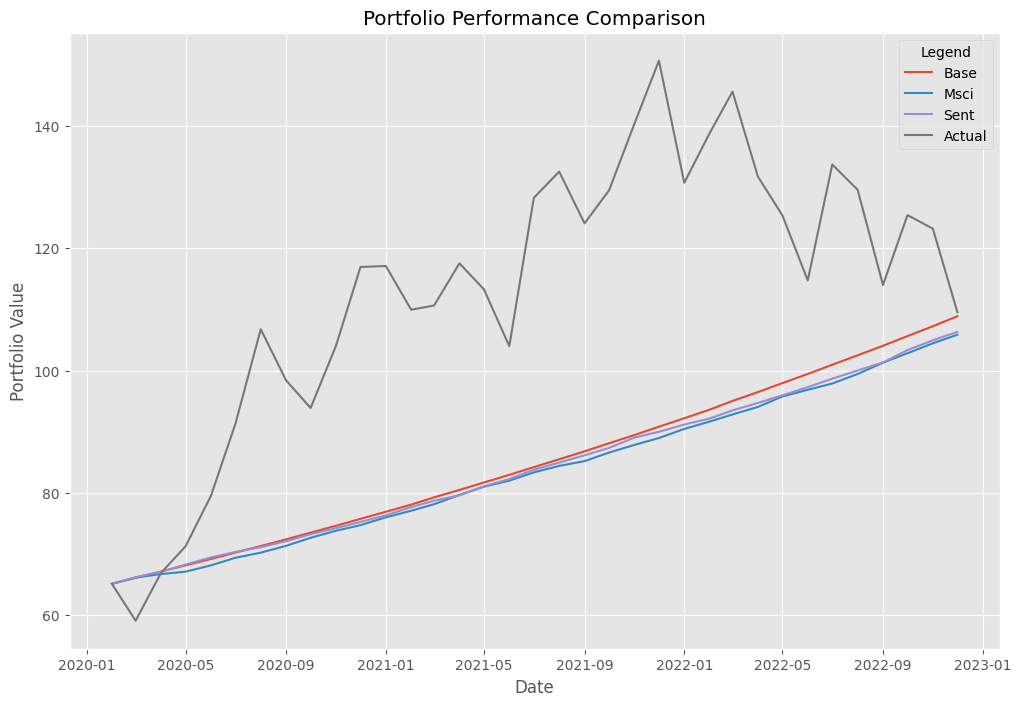

In [976]:

plt.figure(figsize=(12, 8))
plt.style.use('ggplot')

for column in portfolio_series_df.columns:
    plt.plot(portfolio_series_df.index, portfolio_series_df[column], label=column)

plt.title('Portfolio Performance Comparison')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend(title='Legend')
plt.grid(True)

plt.show()
